# Ventilation durations

Query based on the MIMIC ventilation-durations approach to generate a list of start and stop times for mechanical ventilation. 

Currently only looking at `hospitalid = 243`

### Invasive: 
- mean_airway_pressure 
- mv_mode (all simv; all prvc; ac; bi-vent;
- peak_pressure
- plateau_pressure
- ps
- rsbi

### Both invasive and non-invasive: 
- fio2
- mve
- peep

### Weaning trial:
- rsbi

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline

In [5]:
# Create a database connection
user = 'postgres'
host = 'localhost'
dbname = 'eicu'
schema = 'public, eicu_crd_phi'

In [11]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


In [12]:
with open('./ventilation-durations.sql', 'r') as f:
    buildviews_vent = f.read()
cur.execute(buildviews_vent)

# Also interested in the following details in careplangeneral:
# - Do not resuscitate
# - Comfort measures only
# - End of life
# - Terminal

with open('./end-of-life.sql', 'r') as f:
    buildviews_eol = f.read()
cur.execute(buildviews_eol)

In [16]:
query = \
"""
SELECT v.*, 
       max(CASE WHEN e.dnr_offset IS NOT NULL THEN 1 ELSE NULL END) as dnr, 
       max(CASE WHEN e.cmo_offset IS NOT NULL THEN 1 ELSE NULL END) as cmo, 
       max(CASE WHEN e.endoflife_offset IS NOT NULL THEN 1 ELSE NULL END) as endoflife, 
       max(CASE WHEN e.terminal_offset IS NOT NULL THEN 1 ELSE NULL END) as terminal
FROM ventdurations v
LEFT JOIN endoflife e
ON v.patientunitstayid = e.patientunitstayid
GROUP BY v.patientunitstayid, v.ventnum, v.startoffset, v.endoffset,
    v.duration_minutes
ORDER BY patientunitstayid, ventnum;
"""

data = pd.read_sql_query(query,con)

In [18]:
data.head()

,patientunitstayid,ventnum,startoffset,endoffset,duration_minutes,dnr,cmo,endoflife,terminal
0,1433759,1,98,518,420,NaN,NaN,NaN,NaN
1,1433775,1,163,5256,5093,NaN,NaN,NaN,NaN
2,1433775,2,6248,6690,442,NaN,NaN,NaN,NaN
3,1433777,1,45,2720,2675,NaN,NaN,NaN,NaN
4,1433812,1,290,2202,1912,NaN,NaN,NaN,NaN


In [19]:
data.describe()

,patientunitstayid,ventnum,startoffset,endoffset,duration_minutes,dnr,cmo,endoflife,terminal
count,1.455000e+03,1455.000000,1455.000000,1455.000000,1455.000000,294.0,8.0,1.0,5.0
mean,1.493570e+06,1.320275,2021.991065,5074.603436,3052.612371,1.0,1.0,1.0,1.0
std,3.458980e+04,0.824634,5945.002215,7100.634439,4148.142884,0.0,0.0,NaN,0.0
min,1.433759e+06,1.000000,-12640.000000,-12474.000000,10.000000,1.0,1.0,1.0,1.0
25%,1.464251e+06,1.000000,-56.500000,721.500000,484.500000,1.0,1.0,1.0,1.0
50%,1.493804e+06,1.000000,5.000000,2336.000000,1326.000000,1.0,1.0,1.0,1.0
75%,1.523652e+06,1.000000,385.500000,6644.000000,3877.000000,1.0,1.0,1.0,1.0
max,1.553364e+06,8.000000,51439.000000,52318.000000,40756.000000,1.0,1.0,1.0,1.0


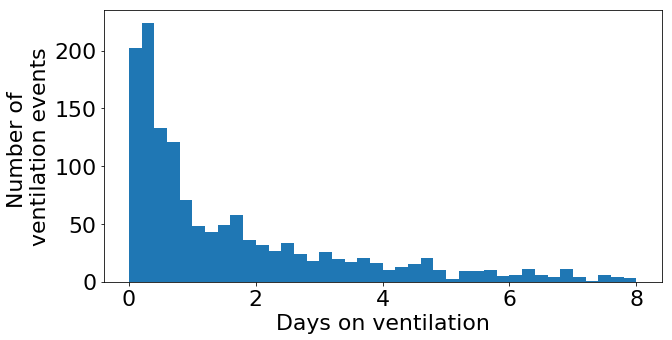

In [35]:
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 22})
ax = plt.hist(data.duration_minutes.values/60/24, bins=40, range=(0, 8))
plt.xlabel('Days on ventilation', fontsize=22)
plt.ylabel('Number of \nventilation events', fontsize=22)

## Notes on `careplangeneral` table

Useful to cross reference following rows in the `cplitemvalue` column:

- Ventilated - chronic dependency
- Ventilated - rapid wean/extubation
- Ventilated - with daily extubation evaluation
- Ventilated - with no daily extubation trial
- Ventilator bundle
- Ventilator wean
- Not intubated/normal airway
- Not intubated/partial airway obstruction
- Intubated/nasal ETT
- Intubated/nasal ETT - difficult
- Intubated/oral ETT
- Intubated/oral ETT - difficult
- Intubated/trach-acute
- Intubated/trach-chronic
- Non-invasive ventilation
- Open to air
- Respiratory Issue

In [36]:
data.to_csv('./hospital_243_vent.csv')